# Fractional differentiate

This notebook will cover exercise answer.

* Exercise 5.4
* Exercise 5.5

As we go along, there will be some explanations.

Stationarity is a key concept in time-series, by now the idea itself has been demostrated in previous notebooks (Feat Importance).

Most of the functions below can be found under research/Features

Contact: boyboi86@gmail.com

In [1]:
import numpy as np
from numba import njit
import pandas as pd
import research as rs
import matplotlib.pyplot as plt

%matplotlib inline

from scipy.stats import jarque_bera

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

p = print

#pls take note of version
#numba 0.49.1 #https://github.com/numba/numba/issues/4255
#numpy 1.17.3
#pandas 1.0.3

dollar = pd.read_csv('./research/Sample_data/dollar_bars.txt', 
                 sep=',', 
                 header=0, 
                 parse_dates = True, 
                 index_col=['date_time'])

# For most part of the func we only use 'close'

close = dollar['close'].to_frame()

Num of CPU core:  4
Machine info:  Windows-10-10.0.18362-SP0
Python 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Numpy 1.17.3
Pandas 1.0.3


C:\Users\Wei_X\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 1500x800 with 1 Axes>

In [2]:
#The same func can be found under research/Feature
@njit
def getWeights(d, size):
    w=[1.]
    for k in np.arange(1,size):
        w_ = -w[-1]/k*(d-k+1)
        w.append(w_)
    w=np.array(w[::-1]).reshape(-1,1)
    return w

def fracDiff(series, d, thres=.01):
    w=getWeights(d, series.shape[0])
    w_=np.cumsum(abs(w))
    w_/=w_[-1]
    skip = w_[w_>thres].shape[0]
    df={}
    for name in series.columns:
        seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series(index=series.index, dtype=float)
        for iloc in range(skip,seriesF.shape[0]):
            loc=seriesF.index[iloc]
            if not np.isfinite(series.loc[loc,name]): continue
            df_[loc]=np.dot(w[-(iloc+1):,:].T,seriesF.loc[:loc])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

@njit
def getWeights_FFD(d, thres):
    w,k=[1.],1
    while True:
        w_ = -w[-1]/k*(d-k+1)
        if abs(w_) < thres:
            break
        w.append(w_); k+=1
    return np.array(w[::-1]).reshape(-1,1)

# need to refactor to optimze if not will take forever if threshold too low
def fracDiff_FFD(series, d, thres=1e-2):
    w, df = getWeights_FFD(d, thres), {}
    width = len(w)-1
    for name in series.columns:
        seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series(index=series.index, dtype=float)
        for iloc in range(width, seriesF.shape[0]):
            loc0, loc1 = seriesF.index[iloc - width], seriesF.index[iloc]
            if not np.isfinite(series.loc[loc1,name]): continue
            df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

def min_value(data: pd.Series, func, thres = 0.01, pval_threshold: float = 0.05):
    d_domain = np.linspace(start = 0, 
                           stop = 2, 
                           num=100, 
                           endpoint=True, 
                           retstep=False, 
                           dtype=float)
    
    for d in d_domain:
        df1 = np.log(data).resample('1D').last() # pls note downcast to daily obs
        df2 = func(df1, d, thres = thres).dropna()
        p(df2)
        df2 = adfuller(df2.squeeze(), maxlag=1, regression='c', autolag=None)
        try:
            if df2[1] <= pval_threshold:
                return d
        except:
            p('Something is wrong! Most likely required d value more than 2!!')

In [3]:
# Take optimal value to pass stationary test
# if you are keen.. adfuller can provide full test result.. go to statsmodel API documentation for more details
# When you run this min_value func from rs, you may encounter memory issue.
test_val = 0.05

log_price = close.apply(np.log)

# this func is the same as others as seen above except input has to be log by users, func will no long do it.
# you have more flexiblility to input log price series or non-log, as well as cumsum()
mv = rs.min_value(data = log_price,
                  FFD = True,
                  thres = 0.01,
                  pval_threshold = test_val,
                  num = 100,
                  num_threads = 21)

# Do not set autolag to 'AIC'
adf_pval = adfuller(fracDiff_FFD(log_price, d=0.141414).dropna().squeeze(), 
                    maxlag=1, 
                    regression='c', 
                    autolag=None)[1]

p("Min d Value: {0:.6f}\nADF pVal: {1:.5f} with critical value: {2}%".format(mv, adf_pval, test_val * 100))

Function used: Fixed Window FD
[               close
date_time           
2015-01-01  7.628882
2015-01-02  7.624741
2015-01-03       NaN
2015-01-04  7.621073
2015-01-05  7.608871
...              ...
2016-12-26       NaN
2016-12-27  7.723894
2016-12-28  7.716572
2016-12-29  7.716795
2016-12-30  7.711997

[730 rows x 1 columns]] this out


2020-05-25 16:33:50.062490 100.0% fracDiff_FFD done after 0.1 minutes. Remaining 0.0 minutes.


[               close
date_time           
2015-01-01       NaN
2015-01-02  7.470622
2015-01-03       NaN
2015-01-04  7.467037
2015-01-05  7.454910
...              ...
2016-12-26       NaN
2016-12-27  7.567874
2016-12-28  7.560534
2016-12-29  7.560904
2016-12-30  7.556102

[730 rows x 1 columns]] this out


2020-05-25 16:33:56.470437 100.0% fracDiff_FFD done after 0.1 minutes. Remaining 0.0 minutes.


[               close
date_time           
2015-01-01       NaN
2015-01-02       NaN
2015-01-03       NaN
2015-01-04  7.068588
2015-01-05  7.056587
...              ...
2016-12-26       NaN
2016-12-27  7.164342
2016-12-28  7.156984
2016-12-29  7.157486
2016-12-30  7.152809

[730 rows x 1 columns]] this out


2020-05-25 16:34:02.859933 100.0% fracDiff_FFD done after 0.1 minutes. Remaining 0.0 minutes.


[               close
date_time           
2015-01-01       NaN
2015-01-02       NaN
2015-01-03       NaN
2015-01-04       NaN
2015-01-05       NaN
...              ...
2016-12-26       NaN
2016-12-27  6.707145
2016-12-28  6.699763
2016-12-29  6.700404
2016-12-30  6.695784

[730 rows x 1 columns]] this out


2020-05-25 16:34:09.089784 100.0% fracDiff_FFD done after 0.09 minutes. Remaining 0.0 minutes.


[               close
date_time           
2015-01-01       NaN
2015-01-02       NaN
2015-01-03       NaN
2015-01-04       NaN
2015-01-05       NaN
...              ...
2016-12-26       NaN
2016-12-27  6.304567
2016-12-28  6.297177
2016-12-29  6.297951
2016-12-30  6.293386

[730 rows x 1 columns]] this out


2020-05-25 16:34:15.352723 100.0% fracDiff_FFD done after 0.09 minutes. Remaining 0.0 minutes.


[               close
date_time           
2015-01-01       NaN
2015-01-02       NaN
2015-01-03       NaN
2015-01-04       NaN
2015-01-05       NaN
...              ...
2016-12-26       NaN
2016-12-27  5.896106
2016-12-28  5.888724
2016-12-29  5.889650
2016-12-30  5.885129

[730 rows x 1 columns]] this out


2020-05-25 16:34:21.623674 100.0% fracDiff_FFD done after 0.09 minutes. Remaining 0.0 minutes.


[               close
date_time           
2015-01-01       NaN
2015-01-02       NaN
2015-01-03       NaN
2015-01-04       NaN
2015-01-05       NaN
...              ...
2016-12-26       NaN
2016-12-27  5.490007
2016-12-28  5.482573
2016-12-29  5.483666
2016-12-30  5.479205

[730 rows x 1 columns]] this out


2020-05-25 16:34:27.884056 100.0% fracDiff_FFD done after 0.09 minutes. Remaining 0.0 minutes.


[               close
date_time           
2015-01-01       NaN
2015-01-02       NaN
2015-01-03       NaN
2015-01-04       NaN
2015-01-05       NaN
...              ...
2016-12-26       NaN
2016-12-27  5.092027
2016-12-28  5.084561
2016-12-29  5.085761
2016-12-30  5.081371

[730 rows x 1 columns]] this out


2020-05-25 16:34:34.446722 100.0% fracDiff_FFD done after 0.1 minutes. Remaining 0.0 minutes.


d value to attain stationarity: 0.141414
Min d Value: 0.141414
ADF pVal: 0.03250 with critical value: 5.0%


In [4]:
ffd0 = fracDiff_FFD(log_price, d = 0.141)

In [5]:
ffd0.describe() # initial num count 24079 before FFD

,close
count,24070.000000
mean,5.036285
std,0.028770
min,4.947561
25%,5.021549
50%,5.040763
75%,5.053797
max,5.102104


In [6]:
ffd1 = fracDiff_FFD(ffd0.dropna(), d = -0.141)

In [7]:
ffd1.describe() # after second FFD based on first FFD but with -d value

,close
count,24047.000000
mean,8.400578
std,0.047928
min,8.256572
25%,8.375772
50%,8.408035
75%,8.429675
max,8.508450


#### Further investgation on negative d value

Even without using FFD twice, just by using a single FFD with -d value. It will still produce NaNs

In [8]:
ffd2 = fracDiff_FFD(ffd1, d = -0.141)

In [9]:
ffd2.describe()

,close
count,24024.000000
mean,14.012257
std,0.079891
min,13.774925
25%,13.970740
50%,14.024726
75%,14.060666
max,14.190578


## Infinite observations

When we try to get weight for FFD, using positive d value will produce appropriate "discount" to observation values.

However, using negative d value we will instead get unlimited "additive" observation values, since we can never get to hit threshold.

In short, convergence will not occur but instead divergence will take place.

#### getWeights_FFD function warning

The function getWeight_FFD would have cause infinite loop when we use negative d value if we did not put a threshold limit condition.

In [10]:
getWeights_FFD(-0.141, 0.01) # negative value which led to divergence (right to left)

array([[0.01016333],
       [0.01055764],
       [0.01098661],
       [0.01145519],
       [0.01196927],
       [0.01253603],
       [0.01316425],
       [0.01386484],
       [0.01465143],
       [0.01554144],
       [0.01655735],
       [0.01772882],
       [0.01909576],
       [0.02071327],
       [0.02265975],
       [0.0250507 ],
       [0.02806408],
       [0.03198967],
       [0.03733476],
       [0.0450794 ],
       [0.0574077 ],
       [0.0804405 ],
       [0.141     ],
       [1.        ]])

In [11]:
getWeights_FFD(0.141, 0.01) # positive value for convergence (left to right)

array([[-0.01050548],
       [-0.01203071],
       [-0.01403203],
       [-0.01676467],
       [-0.02070138],
       [-0.02682221],
       [-0.0375267 ],
       [-0.0605595 ],
       [-0.141     ],
       [ 1.        ]])

#### Exercise 5.5

In [12]:
log_price.head(6)

,close
date_time,
2015-01-01 23:00:23.723,7.628882
2015-01-02 07:07:35.156,7.632401
2015-01-02 09:35:57.204,7.630704
2015-01-02 12:59:42.176,7.630947
2015-01-02 14:19:33.847,7.632280
2015-01-02 14:33:39.311,7.632643


In [13]:
cumsum_logp = log_price.cumsum()
cumsum_logp.dropna(inplace = True)
cumsum_logp.describe() #initial count 24079 if no NaNs count should be same

,close
count,24079.000000
mean,91747.193481
std,52961.243656
min,7.628882
25%,45974.457645
50%,91742.869713
75%,137500.145350
max,183724.410799


In [14]:
cumsum_logp.head(6)

,close
date_time,
2015-01-01 23:00:23.723,7.628882
2015-01-02 07:07:35.156,15.261283
2015-01-02 09:35:57.204,22.891987
2015-01-02 12:59:42.176,30.522934
2015-01-02 14:19:33.847,38.155214
2015-01-02 14:33:39.311,45.787857


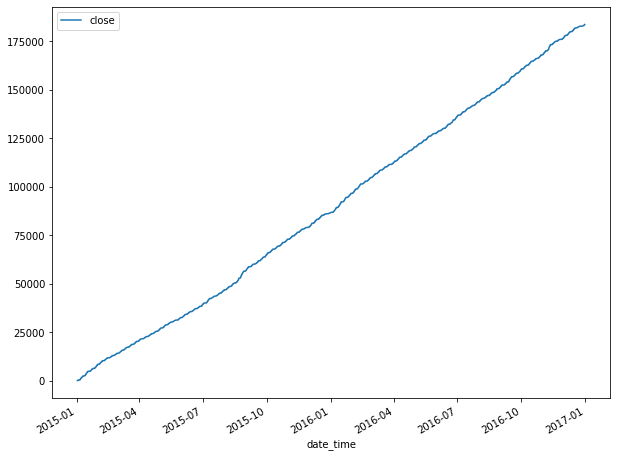

In [15]:
cumsum_logp.plot(figsize=(10,8)) # literally a straight line

**Note**

Cumumlative sum prices use threshold 1.e-5.

Non-cumumlative prices use threshold 1.e-2.

Otherwise threshold is too low.

Log prices in theory may improve convergence, you may wish to check max likelihood estimation or AIC score.

In [16]:
# this is a sample func on per tick, DO NOT use it otherwise it will take forever if per tick.

def minVal_cs(data: pd.Series, thres: float = 1e-5, pval_threshold: float = 0.05, d_range: list = [1.9, 2.0] ):
    d_domain = np.linspace(start = d_range[0], 
                           stop = d_range[1], 
                           num=1e9, 
                           endpoint=True, 
                           retstep=False, 
                           dtype=float)
    
    for d in d_domain:
        try:
            df1 = np.log(data).cumsum() #.resample('1h').last()# pls note downcast to daily obs
            df1.dropna(inplace=True)
            df2 = fracDiff_FFD(df1, d, thres = thres).dropna()
            df2 = adfuller(df2.squeeze(), maxlag = 1,regression='c', autolag=None)
            if df2[1] <= pval_threshold:
                print(d)
                return d
        except:
            p('Something is wrong! Most likely required d value beyond input parameter!!')

In [17]:
# Kindly refer to the ans d = 1.99999889 instead to save time, it may even crash

#even with multiprocessing running this func will still take some time
"""
mv = rs.min_value(data = cumsum_logp,
                  FFD = True,
                  thres = 1e-5,
                  pval_threshold = test_val,
                  num = 1e9,
                  num_threads = 21)
"""

minVal_cs(data = cumsum_logp, thres = 1e-5, pval_threshold = 0.05, d_range = [1.9999, 2.0])

1.99999889


**Note**

If you cumulative sum your financial time-series, before FFD. 

You will need to differentiate and in this case min d value is very close 2.0

In [18]:
# if d value was 1.999999 ADF p value would be 0.01695 < 0.04165 < 0.05
ffd3 = fracDiff_FFD(cumsum_logp, 
                    d = 1.99999889, 
                    thres=1e-5
                   ).dropna()

adf_pval = adfuller(ffd3.squeeze(), 
                    maxlag = 1,
                    regression='c', 
                    autolag=None)[1]

p("\nADF pVal: {0:.5f} with critical value: {1}%".format(adf_pval, test_val * 100))


ADF pVal: 0.04165 with critical value: 5.0%


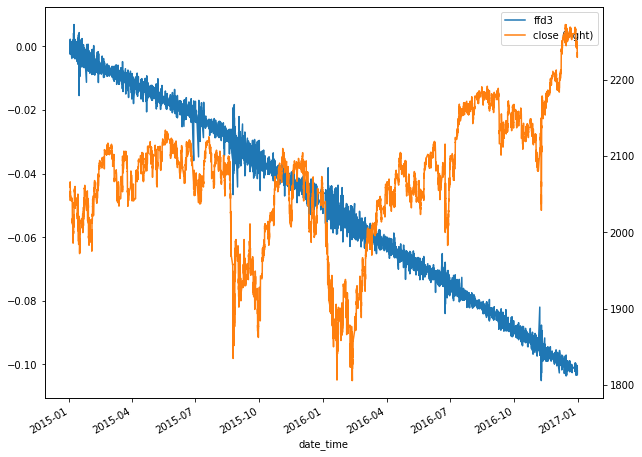

In [19]:
fracdiff_series = pd.DataFrame(index=ffd3.index).assign(ffd3 = ffd3, #after fractional differentiate
                                                        cumsum_logp = cumsum_logp, #cumulative sum of log price
                                                        close = close) #original

fracdiff_series[['ffd3', 'close']].plot(secondary_y='close', figsize=(10,8)) #not even remotely close

,ffd3,cumsum_logp,close
ffd3,1.000000,-0.998939,-0.405165
cumsum_logp,-0.998939,1.000000,0.406330
close,-0.405165,0.406330,1.000000


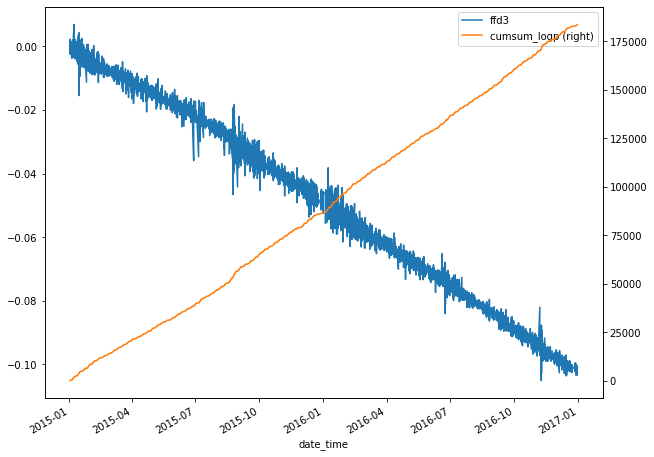

In [20]:
fracdiff_series[['ffd3', 'cumsum_logp']].plot(secondary_y='cumsum_logp', figsize=(10,8)) #not even remotely close

fracdiff_series.corr(method='pearson') # see correlation matrix

In [21]:
p("ADF pVal for original time-series: {0}\n".format(adfuller(fracdiff_series['close'], 
                                  maxlag = 1, 
                                  regression = 'c', 
                                  autolag=None)[1]))

p("ADF pVal for acummulative log price time-series: {0}\n".format(adfuller(fracdiff_series['cumsum_logp'], 
                                  maxlag = 1, 
                                  regression = 'c', 
                                  autolag=None)[1]))

# time-series is not stationary since p-value is more than 0.05

p("Jarque Bera pVal: {0:.5f}\n".format(jarque_bera(fracdiff_series['ffd3'])[1]))

# time-series is not normal since p value is less than 0.05

result = coint(fracdiff_series['ffd3'], fracdiff_series['close'], maxlag = 1, trend = 'c', autolag = None)

p("Engel-Granger Coint pVal: {0}".format(result[1]))

# there is a long term relationship since p-value is less than 0.05

ADF pVal for original time-series: 0.29394421553033817

ADF pVal for acummulative log price time-series: 0.9979035515620875

Jarque Bera pVal: 0.00000

Engel-Granger Coint pVal: 0.009683330960666188


### Memory Persistance

ADF p-val for original was 0.2939. Corr against FFD was -0.405165, inverse relation.

ADF p-val for cumsum log price was 0.9979. Corr against FFD was -0.9989, inverse relation.

ADF p-val for FFD using d value 1.99999889 was 0.04165.(Stationary).

Coint p-val for FFD and original was 0.009683.

Initially we preserve time series memory by log price, however as we cumsum the log price time series we cause these memory to accumulate which increases ADF p-value and more "unstationary" since we created a linear trend.

In most cases, d value was less than 1 but due to this new cumsum log price we end up using above 1 which will cause "decay" to be very aggressive which is reflected in the graph ffd3 vs original time series.

However, when perform Engel-Granger Coint test, test result states the two seemingly negatively correlated time-series do have a long term relationship. Most likely due to the memory persistance, which achieved p-value of 0.009683 lower than critical size 0.01.

>"Log prices have memory but are non-stationary. Cointegration is the trick that makes regression works on non-stationary series, so that memory is preserved."
>
> Advances in Financial Machine Learning, page 88, section 5.7

### Conclusion

This is an important finding since we require a stationary series with maximum memory preserved to ensure machine learning use it as key predictive feature effectively.